# Tentacle scaling benchmark
This file documents the scaling benchmark which is part of the Tentacle publication (Boulund et al., 2015). 
For more information on Tentacle, see the Tentacle webpage and online documentation at http://bioinformatics.math.chalmers.se/tentacle/

## Test setup
Tentacle was run three times on 1, 2, 4, 8, 16, and 32 nodes, respectively. The evaluations were run on the [C3SE cluster *Glenn*](http://c3se.chalmers.se), using `pblat` (http://icebert.github.io/pblat/) for mapping nucleotide reads to nucleotide reference sequences.

### Data used 
The data used for the evaluation of the scaling performance of Tentacle was taken from Qin et al. (2010) (doi:[10.1038/nature08821](http://dx.doi.org/10.1038/nature08821)).
The files were put on the distributed file system on Glenn and were supplied to Tentacle in compressed FASTQ format. Tentacle's default values for all parameters were used in this evaluation, unless otherwise stated.

**Reads**: The first file of the first sample of Qin et al. (2010) was used in the evaluation. The file was duplicated $N*r$ times ($N$ is the number of nodes, $r$ is the number of replicates (3)) for each run to remove the impact of file system caching effects.

**References**: The references used in the evaluation were the per sample assembled contigs published together with the raw read data in Qin et al. 2010.

**Annotations**: The annotations used in the evaluation were an antibiotic restistance gene annotation of the per sample assembled contigs, performed using RESQU v. 1.1 (http://www.1928diagnostics.com/resdb/).

The following sample was used (in duplicates) in the performance evaluation: `MH0001_081026.raw.1`

### Run order
The run order was randomized to minimize the impact of any time-associated effects (e.g. cluster/network load). The final run order was the following (the format is `N_r`, N=number of nodes, r=replicate): `16_3, 08_2, 01_1, 08_1, 04_1, 02_3, 16_2, 32_2, 32_3, 01_3, 08_3, 04_2, 16_1, 01_2, 32_1, 02_2, 02_1, 04_3`.

## Tentacle settings 
The following command line flags were used when running the benchmark:

    --pblat                                      tell Tentacle to use pblat as mapper
    --mappingManifest <PATH>                     path to mapping manifest file (w/ absolute paths to
                                                 reads, references, annotations)
    -N <N>                                       number of nodes to run
    -o <DIR>                                     output directory
    --localCoordinator                           tell Tentacle to run the master process on the login node
    --distributionUseDedicatedCoordinatorNode    tell Tentacle to not run any work on the same node as the master process
    --slurmAccount <ACCOUNT>                     specify what Slurm account to run on
    --slurmTimeLimit <TIMELIMIT>                 set a per node time limit for each submitted Slurm job
    --slurmJobName <JOBNAME>                     set a descriptive name for each submitted Slurm job

## Runtimes
Tentacle writes run times for each run into `run_summary.txt` files. The runtimes were collected (using `grep`) and used to compute the scaling characteristics of the Tentacle framework. Waiting times in the queuing system on Glenn were disregarded in this evaluation. Note that the total work was increased proportionally with the number of nodes, so constant time with increasing node count implies perfect scaling behavior. 

In [1]:
# Load required libraries and define some functions required to compute plot data
import matplotlib
matplotlib.use("Agg")
%matplotlib inline
from pylab import *
import numpy as np
from scipy.stats import sem

def get_seconds(s):
    hours, minutes, seconds = s.split(':')
    seconds = round(float(seconds))
    return int(hours) * 3600 + int(minutes) * 60 + int(seconds)

In [25]:
# Runtimes are put into this multiline string and then parsed into a numpy array.
# Extract runtimes from Tentacle output like this: 
# $ grep Runtime benchmark*/run_summary.txt
raw_runtimes = """bench_01_node2/run_summary.txt:  Runtime:               0:07:10.466514
bench_01_node3/run_summary.txt:  Runtime:               0:07:12.470428
bench_01_node/run_summary.txt:  Runtime:               0:07:10.460746 
bench_02_node2/run_summary.txt:  Runtime:               0:07:11.495809
bench_02_node2/run_summary.txt:  Runtime:               0:07:25.527506
bench_02_node3/run_summary.txt:  Runtime:               0:07:14.062938
bench_02_node3/run_summary.txt:  Runtime:               0:07:19.241400
bench_02_node/run_summary.txt:  Runtime:               0:07:12.824100 
bench_02_node/run_summary.txt:  Runtime:               0:07:06.752624 
bench_04_node2/run_summary.txt:  Runtime:               0:07:15.668600
bench_04_node2/run_summary.txt:  Runtime:               0:07:08.780827
bench_04_node2/run_summary.txt:  Runtime:               0:07:11.951277
bench_04_node2/run_summary.txt:  Runtime:               0:07:11.494167
bench_04_node3/run_summary.txt:  Runtime:               0:07:23.947469
bench_04_node3/run_summary.txt:  Runtime:               0:07:17.054728
bench_04_node3/run_summary.txt:  Runtime:               0:07:16.678286
bench_04_node3/run_summary.txt:  Runtime:               0:07:53.982303
bench_04_node/run_summary.txt:  Runtime:               0:07:14.325432 
bench_04_node/run_summary.txt:  Runtime:               0:07:22.275700 
bench_04_node/run_summary.txt:  Runtime:               0:07:21.313997 
bench_04_node/run_summary.txt:  Runtime:               0:07:20.956850 
bench_08_node2/run_summary.txt:  Runtime:               0:07:22.449105
bench_08_node2/run_summary.txt:  Runtime:               0:07:29.888130
bench_08_node2/run_summary.txt:  Runtime:               0:07:38.409101
bench_08_node2/run_summary.txt:  Runtime:               0:07:28.624146
bench_08_node2/run_summary.txt:  Runtime:               0:07:11.756534
bench_08_node2/run_summary.txt:  Runtime:               0:07:16.305811
bench_08_node2/run_summary.txt:  Runtime:               0:07:16.187047
bench_08_node2/run_summary.txt:  Runtime:               0:07:29.200394
bench_08_node3/run_summary.txt:  Runtime:               0:07:11.381415
bench_08_node3/run_summary.txt:  Runtime:               0:07:16.061901
bench_08_node3/run_summary.txt:  Runtime:               0:07:22.979757
bench_08_node3/run_summary.txt:  Runtime:               0:07:16.738831
bench_08_node3/run_summary.txt:  Runtime:               0:07:23.038733
bench_08_node3/run_summary.txt:  Runtime:               0:07:28.563114
bench_08_node3/run_summary.txt:  Runtime:               0:07:16.224309
bench_08_node3/run_summary.txt:  Runtime:               0:07:20.968339
bench_08_node/run_summary.txt:  Runtime:               0:07:14.145012 
bench_08_node/run_summary.txt:  Runtime:               0:07:10.658345 
bench_08_node/run_summary.txt:  Runtime:               0:07:13.483490 
bench_08_node/run_summary.txt:  Runtime:               0:07:09.401658 
bench_08_node/run_summary.txt:  Runtime:               0:07:19.899452 
bench_08_node/run_summary.txt:  Runtime:               0:07:16.264064 
bench_08_node/run_summary.txt:  Runtime:               0:07:23.405971 
bench_08_node/run_summary.txt:  Runtime:               0:07:16.690204 
bench_16_node2/run_summary.txt:  Runtime:               0:07:09.847246
bench_16_node2/run_summary.txt:  Runtime:               0:07:19.743257
bench_16_node2/run_summary.txt:  Runtime:               0:07:20.782261
bench_16_node2/run_summary.txt:  Runtime:               0:07:19.172778
bench_16_node2/run_summary.txt:  Runtime:               0:07:11.782728
bench_16_node2/run_summary.txt:  Runtime:               0:07:18.445111
bench_16_node2/run_summary.txt:  Runtime:               0:07:17.757168
bench_16_node2/run_summary.txt:  Runtime:               0:07:24.354032
bench_16_node2/run_summary.txt:  Runtime:               0:07:22.218816
bench_16_node2/run_summary.txt:  Runtime:               0:07:23.135351
bench_16_node2/run_summary.txt:  Runtime:               0:07:24.927615
bench_16_node2/run_summary.txt:  Runtime:               0:07:24.651256
bench_16_node2/run_summary.txt:  Runtime:               0:07:16.008662
bench_16_node2/run_summary.txt:  Runtime:               0:07:21.043731
bench_16_node2/run_summary.txt:  Runtime:               0:07:11.899647
bench_16_node2/run_summary.txt:  Runtime:               0:07:19.313781
bench_16_node3/run_summary.txt:  Runtime:               0:07:17.460310
bench_16_node3/run_summary.txt:  Runtime:               0:07:09.370250
bench_16_node3/run_summary.txt:  Runtime:               0:07:07.970690
bench_16_node3/run_summary.txt:  Runtime:               0:07:09.651710
bench_16_node3/run_summary.txt:  Runtime:               0:07:15.487784
bench_16_node3/run_summary.txt:  Runtime:               0:07:19.695767
bench_16_node3/run_summary.txt:  Runtime:               0:07:21.048790
bench_16_node3/run_summary.txt:  Runtime:               0:07:18.471086
bench_16_node3/run_summary.txt:  Runtime:               0:07:18.919551
bench_16_node3/run_summary.txt:  Runtime:               0:07:18.087734
bench_16_node3/run_summary.txt:  Runtime:               0:07:24.919127
bench_16_node3/run_summary.txt:  Runtime:               0:07:19.637477
bench_16_node3/run_summary.txt:  Runtime:               0:07:13.602282
bench_16_node3/run_summary.txt:  Runtime:               0:07:25.022562
bench_16_node3/run_summary.txt:  Runtime:               0:07:11.913889
bench_16_node3/run_summary.txt:  Runtime:               0:07:52.559387
bench_16_node/run_summary.txt:  Runtime:               0:07:12.382541 
bench_16_node/run_summary.txt:  Runtime:               0:07:19.902345 
bench_16_node/run_summary.txt:  Runtime:               0:07:16.502746 
bench_16_node/run_summary.txt:  Runtime:               0:07:17.170045 
bench_16_node/run_summary.txt:  Runtime:               0:07:16.004685 
bench_16_node/run_summary.txt:  Runtime:               0:07:14.482009 
bench_16_node/run_summary.txt:  Runtime:               0:07:11.956000 
bench_16_node/run_summary.txt:  Runtime:               0:07:17.568644 
bench_16_node/run_summary.txt:  Runtime:               0:07:17.743969 
bench_16_node/run_summary.txt:  Runtime:               0:07:16.862035 
bench_16_node/run_summary.txt:  Runtime:               0:07:20.068226 
bench_16_node/run_summary.txt:  Runtime:               0:07:10.549423 
bench_16_node/run_summary.txt:  Runtime:               0:07:16.357174 
bench_16_node/run_summary.txt:  Runtime:               0:07:21.319076 
bench_16_node/run_summary.txt:  Runtime:               0:07:19.944745 
bench_16_node/run_summary.txt:  Runtime:               0:07:24.941155 
bench_32_node2/run_summary.txt:  Runtime:               0:07:13.802706
bench_32_node2/run_summary.txt:  Runtime:               0:07:13.398711
bench_32_node2/run_summary.txt:  Runtime:               0:07:31.313374
bench_32_node2/run_summary.txt:  Runtime:               0:07:12.621549
bench_32_node2/run_summary.txt:  Runtime:               0:07:10.340637
bench_32_node2/run_summary.txt:  Runtime:               0:07:13.271370
bench_32_node2/run_summary.txt:  Runtime:               0:07:15.497294
bench_32_node2/run_summary.txt:  Runtime:               0:07:09.098259
bench_32_node2/run_summary.txt:  Runtime:               0:07:16.582165
bench_32_node2/run_summary.txt:  Runtime:               0:07:11.504647
bench_32_node2/run_summary.txt:  Runtime:               0:07:19.892005
bench_32_node2/run_summary.txt:  Runtime:               0:07:18.719723
bench_32_node2/run_summary.txt:  Runtime:               0:07:22.284715
bench_32_node2/run_summary.txt:  Runtime:               0:07:22.188147
bench_32_node2/run_summary.txt:  Runtime:               0:07:21.108520
bench_32_node2/run_summary.txt:  Runtime:               0:07:18.043764
bench_32_node2/run_summary.txt:  Runtime:               0:07:24.842230
bench_32_node2/run_summary.txt:  Runtime:               0:07:39.419400
bench_32_node2/run_summary.txt:  Runtime:               0:07:18.400728
bench_32_node2/run_summary.txt:  Runtime:               0:07:22.370852
bench_32_node2/run_summary.txt:  Runtime:               0:07:17.287102
bench_32_node2/run_summary.txt:  Runtime:               0:07:19.497067
bench_32_node2/run_summary.txt:  Runtime:               0:07:16.944225
bench_32_node2/run_summary.txt:  Runtime:               0:07:20.752113
bench_32_node2/run_summary.txt:  Runtime:               0:07:20.517088
bench_32_node2/run_summary.txt:  Runtime:               0:07:20.910442
bench_32_node2/run_summary.txt:  Runtime:               0:07:22.618973
bench_32_node2/run_summary.txt:  Runtime:               0:07:40.485352
bench_32_node2/run_summary.txt:  Runtime:               0:07:12.606160
bench_32_node2/run_summary.txt:  Runtime:               0:07:23.227982
bench_32_node2/run_summary.txt:  Runtime:               0:07:27.117009
bench_32_node3/run_summary.txt:  Runtime:               0:07:17.669789
bench_32_node3/run_summary.txt:  Runtime:               0:07:16.161698
bench_32_node3/run_summary.txt:  Runtime:               0:07:12.834358
bench_32_node3/run_summary.txt:  Runtime:               0:07:27.052818
bench_32_node3/run_summary.txt:  Runtime:               0:07:49.947251
bench_32_node3/run_summary.txt:  Runtime:               0:07:16.090502
bench_32_node3/run_summary.txt:  Runtime:               0:07:21.358071
bench_32_node3/run_summary.txt:  Runtime:               0:07:22.903849
bench_32_node3/run_summary.txt:  Runtime:               0:07:21.462802
bench_32_node3/run_summary.txt:  Runtime:               0:07:37.275537
bench_32_node3/run_summary.txt:  Runtime:               0:07:25.520263
bench_32_node3/run_summary.txt:  Runtime:               0:07:56.399265
bench_32_node3/run_summary.txt:  Runtime:               0:07:21.431036
bench_32_node3/run_summary.txt:  Runtime:               0:07:21.674509
bench_32_node3/run_summary.txt:  Runtime:               0:07:21.186782
bench_32_node3/run_summary.txt:  Runtime:               0:07:35.631747
bench_32_node3/run_summary.txt:  Runtime:               0:07:22.754275
bench_32_node3/run_summary.txt:  Runtime:               0:07:59.020339
bench_32_node3/run_summary.txt:  Runtime:               0:07:19.538140
bench_32_node3/run_summary.txt:  Runtime:               0:07:23.864055
bench_32_node3/run_summary.txt:  Runtime:               0:07:24.957464
bench_32_node3/run_summary.txt:  Runtime:               0:07:24.185251
bench_32_node3/run_summary.txt:  Runtime:               0:07:33.682141
bench_32_node3/run_summary.txt:  Runtime:               0:08:00.331604
bench_32_node3/run_summary.txt:  Runtime:               0:07:23.734585
bench_32_node3/run_summary.txt:  Runtime:               0:07:25.055632
bench_32_node3/run_summary.txt:  Runtime:               0:07:24.002971
bench_32_node3/run_summary.txt:  Runtime:               0:07:17.596772
bench_32_node3/run_summary.txt:  Runtime:               0:07:26.339764
bench_32_node3/run_summary.txt:  Runtime:               0:07:36.376342
bench_32_node3/run_summary.txt:  Runtime:               0:07:55.856985
bench_32_node3/run_summary.txt:  Runtime:               0:07:19.682746
bench_32_node/run_summary.txt:  Runtime:               0:07:11.367731
bench_32_node/run_summary.txt:  Runtime:               0:07:12.162599
bench_32_node/run_summary.txt:  Runtime:               0:07:26.364204
bench_32_node/run_summary.txt:  Runtime:               0:07:17.692020
bench_32_node/run_summary.txt:  Runtime:               0:07:20.197082
bench_32_node/run_summary.txt:  Runtime:               0:07:35.697001
bench_32_node/run_summary.txt:  Runtime:               0:07:18.081268
bench_32_node/run_summary.txt:  Runtime:               0:07:19.916048
bench_32_node/run_summary.txt:  Runtime:               0:07:33.562442
bench_32_node/run_summary.txt:  Runtime:               0:07:11.681859
bench_32_node/run_summary.txt:  Runtime:               0:07:16.945423
bench_32_node/run_summary.txt:  Runtime:               0:07:18.981785
bench_32_node/run_summary.txt:  Runtime:               0:07:34.078212
bench_32_node/run_summary.txt:  Runtime:               0:07:19.808309
bench_32_node/run_summary.txt:  Runtime:               0:07:16.028817
bench_32_node/run_summary.txt:  Runtime:               0:07:17.027196
bench_32_node/run_summary.txt:  Runtime:               0:07:19.571245
bench_32_node/run_summary.txt:  Runtime:               0:07:35.636204
bench_32_node/run_summary.txt:  Runtime:               0:07:21.921948
bench_32_node/run_summary.txt:  Runtime:               0:07:15.983512
bench_32_node/run_summary.txt:  Runtime:               0:07:17.573210
bench_32_node/run_summary.txt:  Runtime:               0:07:23.385873
bench_32_node/run_summary.txt:  Runtime:               0:07:11.627138
bench_32_node/run_summary.txt:  Runtime:               0:07:18.136978
bench_32_node/run_summary.txt:  Runtime:               0:07:15.051222
bench_32_node/run_summary.txt:  Runtime:               0:07:31.217121
bench_32_node/run_summary.txt:  Runtime:               0:07:21.524185
bench_32_node/run_summary.txt:  Runtime:               0:07:22.142888
bench_32_node/run_summary.txt:  Runtime:               0:07:25.324486
bench_32_node/run_summary.txt:  Runtime:               0:07:25.048607
bench_32_node/run_summary.txt:  Runtime:               0:07:17.594498
bench_32_node/run_summary.txt:  Runtime:               0:07:12.552391"""

In [26]:
# Fill a nested list with runtimes
runtimes = [[], [], [], [], [], []]
indexes = {1: 0, 2: 1, 4: 2, 8: 3, 16: 4, 32: 5}
for line in raw_runtimes.split("\n"):
    run_summary, _, runtime = line.split()
    run = int(run_summary.split("_", 2)[1])
    runtimes[indexes[run]].append(get_seconds(runtime))

In [27]:
# Compute average runtimes and throughput for each number of nodes
throughputs = []
# Total number of reads processed per Tentacle run
reads = [11706305, 11706305*2, 11706305*4, 11706305*8, 11706305*16, 11706305*32] 

for num, run_runtimes in zip(reads, runtimes):
    throughputs.append([num/runtime for runtime in run_runtimes])
avg_throughputs = [sum(a)/len(a) for a in throughputs]
speedups = [float(t)/avg_throughputs[0] for t in avg_throughputs]
stderrs = [sem(t) for t in runtimes]

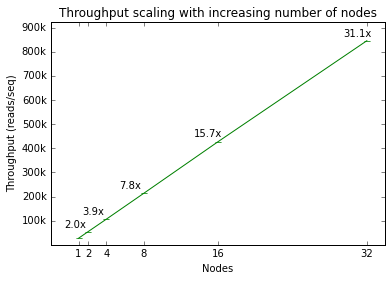

In [28]:
# Create scaling plot
nodes = sorted(indexes.keys())

fig = figure()
errorbar(nodes, avg_throughputs, yerr=stderrs, color="g")
xlim(-2,34) # to give room for the speedup text labels
ylim(0,925000) # to give room for the speedup text labels
yticks([(t*100000) for t in xrange(1,10)], ["{}k".format(t*100) for t in xrange(1,10)])
xticks(nodes)
xlabel("Nodes")
ylabel("Throughput (reads/seq)")
title("Throughput scaling with increasing number of nodes")

# Annotate all points with speedup (except the first)
for speedup, node, throughput in zip(speedups, nodes, avg_throughputs)[1:]:
    annotate("{:2.1f}x".format(speedup), 
             xy=(node, throughput), 
             xytext=(node-2.5, throughput+20000))

fig.savefig("scaling.svg")
fig.savefig("scaling.png")

In [29]:
print "Nodes  Throughput(avg)  Stderr  Speedup"
for node, throughput, stderr, speedup in zip(nodes, avg_throughputs, stderrs, speedups):
    print "{:<5}  {:>15}  {:>6.2f}  {:>7.3f}".format(node, throughput, stderr, speedup)

Nodes  Throughput(avg)  Stderr  Speedup
1                27181    0.67    1.000
2                53832    2.72    1.981
4               106526    3.39    3.919
8               213078    1.49    7.839
16              427338    0.99   15.722
32              845680    1.06   31.113
